# Pràctica
En aquesta pràctica, realitzada per Artur Aubach Altés i Llum Fuster Palà, es desenvolupa un identificador de idioma a partir d'unes dades donades de 6 idiomes: Alemany, Anglès. 
La pràctica es divideix en 3 parts: en la primera està la implementació de l'identificador d'idioma, en la segona trobem una anàlisi dels resultats per a les nostres dades de test i en la última hem implementat una petita iterfície per a poder identificar l'idioma del teu propi text.

## Carga de llibreries i documents

In [1]:
#Llibreries necessàries
import re
from nltk.collocations import TrigramCollocationFinder
from collections import Counter
import numpy as np
from math import e
import time

In [2]:
# Llegim dades de training
f1 = open('dades/deu_trn.txt', encoding="utf8")
tr_deu= f1.readlines()
f2 = open('dades/eng_trn.txt', encoding="utf8")
tr_eng = f2.readlines()
f3 = open('dades/fra_trn.txt', encoding="utf8")
tr_fra = f3.readlines()
f4 = open('dades/ita_trn.txt', encoding="utf8")
tr_ita = f4.readlines()
f5 = open('dades/nld_trn.txt', encoding="utf8")
tr_nld = f5.readlines()
f6 = open('dades/spa_trn.txt', encoding="utf8")
tr_spa = f6.readlines()

## Preprocessing
Funcions que ens serviran per a preparar les nostres dades, tant de training com de test

### Funsions Base

Les següents funcions requereixen d'un sol paràmetre que és una llista de strings amb cada una de les frases d'un document

In [3]:
#Passar a minusculas
def convertir_minusculas(dades):
    for i in range(len(dades)):
        dades[i] = dades[i].lower()
    return dades

In [4]:
# Eliminar nombres, dates, hores, percentatges, marcadors d'ordre i punt final de frase que no aporta informació sobre l'idioma i crea més tri-grams
def elimina_nombres(dades):
    for i in range(len(dades)):
        dades[i] = re.sub(r"\d+\t|\d+[.,-:]?\d?%?|\d+\s-|.$", "", dades[i])
    return dades

In [5]:
# Eliminem els espais repetits i els substituim per un sol espai
def elimina_espais_repetits(dades):
    for i in range(len(dades)):
        dades[i] = re.sub(pattern=r'\s\s+', repl =' ' , string=dades[i])
    return dades

In [6]:
#Afegir 2 espais a inici i final de frase:
def afegir_espais_frases(dades):
    for i in range(len(dades)):
        dades[i] = '  ' + dades[i]+ '  '
    return dades

### Funcions Extensió

In [7]:
# Crear una llista amb caràcters del llenguatge
## Crear llista buida
caracters = []

## Afegir els caràcters de l'alfabet llatí bàsic
for lletra in "abcdefghijklmnopqrstuvwxyz":
  caracters.append(lletra)

## Afegir els caràcters especials de cada llengua
caracters.extend(["á", "é", "í", "ó", "ú", "ü", "ñ"])  # Espanyol
caracters.extend(["à", "è", "ì", "ò", "ù"])  # Italiano
caracters.extend(["â", "ê", "î", "ô", "û", "ç"])  # Francès
caracters.extend(["ä", "ë", "ï", "ö", "ü"])  # Alemany y Neerlandès
caracters.extend(["ß"])  # Alemany
caracters.extend(["æ", "œ", "ç", "ë", "ï", "ü", "ÿ"])  # Francès

print(caracters)


['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'á', 'é', 'í', 'ó', 'ú', 'ü', 'ñ', 'à', 'è', 'ì', 'ò', 'ù', 'â', 'ê', 'î', 'ô', 'û', 'ç', 'ä', 'ë', 'ï', 'ö', 'ü', 'ß', 'æ', 'œ', 'ç', 'ë', 'ï', 'ü', 'ÿ']


In [8]:

#Afegir signes
## Afegir els signes de puntuació comuns a tots els idiomes i espais en blanc
caracters.extend([".", ",", ";", ":", "?", "!", "(", ")",
             "[", "]", "{", "}", "'", "\"", " "])

## Afegir els signes de puntuació específics de cada idioma
caracters.extend(["¿", "¡"])  # Espanyol
caracters.extend(["«", "»"])  # Francès y espanyol
caracters.extend(["„", "“"])  # Alemany y Neerlandès
caracters.extend(["…"])  # Francès y alemany


print(caracters)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'á', 'é', 'í', 'ó', 'ú', 'ü', 'ñ', 'à', 'è', 'ì', 'ò', 'ù', 'â', 'ê', 'î', 'ô', 'û', 'ç', 'ä', 'ë', 'ï', 'ö', 'ü', 'ß', 'æ', 'œ', 'ç', 'ë', 'ï', 'ü', 'ÿ', '.', ',', ';', ':', '?', '!', '(', ')', '[', ']', '{', '}', "'", '"', ' ', '¿', '¡', '«', '»', '„', '“', '…']


In [9]:
# Eliminar caracters especifics del text
def filtrar_texto(dades, llista):
   for i in range(len(dades)):
      text_filtrat = ""
      for caracter in dades[i]:
         if caracter in llista:
            text_filtrat += caracter
      dades[i] = text_filtrat
   return dades


### Executar preprocessing

In [10]:
# Si volem el preprocessing base:
for i in [tr_deu,tr_eng,tr_fra,tr_ita,tr_nld,tr_spa]:
    i = afegir_espais_frases(elimina_espais_repetits(elimina_nombres(convertir_minusculas(i))))

In [11]:
# si volem el preprocessing extensió:
tr_deu_extensio = afegir_espais_frases(filtrar_texto(elimina_espais_repetits(elimina_nombres(convertir_minusculas(tr_deu))),caracters))
tr_eng_extensio = afegir_espais_frases(filtrar_texto(elimina_espais_repetits(elimina_nombres(convertir_minusculas(tr_eng))),caracters))
tr_fra_extensio = afegir_espais_frases(filtrar_texto(elimina_espais_repetits(elimina_nombres(convertir_minusculas(tr_fra))),caracters))
tr_ita_extensio = afegir_espais_frases(filtrar_texto(elimina_espais_repetits(elimina_nombres(convertir_minusculas(tr_ita))),caracters))
tr_nld_extensio = afegir_espais_frases(filtrar_texto(elimina_espais_repetits(elimina_nombres(convertir_minusculas(tr_nld))),caracters))
tr_spa_extensio = afegir_espais_frases(filtrar_texto(elimina_espais_repetits(elimina_nombres(convertir_minusculas(tr_spa))),caracters))

## Trigrams

### Funcions

In [12]:
# generar trigrames d'una llista, amb la freqüència en què apareixen
def tri_gram(dades):
    x = Counter()
    for i in dades:
        finder = TrigramCollocationFinder.from_words(i)
        for ngram, freq in finder.ngram_fd.items():
            x[ngram] += freq
    return x

In [13]:
# filtrar tri-grams amb més de 5 aparicions
def filtrar_aparicions(dades,valor):
    for i in dades:
        if dades[i] < valor:
            dades[i] = 0
    return dades

### Aplicació a les dades d'entrenament

In [14]:
# extraiem els trigrams de les dades de train en un counter
tr_deu = tri_gram(tr_deu)
tr_eng = tri_gram(tr_eng)
tr_fra = tri_gram(tr_fra)
tr_ita = tri_gram(tr_ita)
tr_nld = tri_gram(tr_nld)
tr_spa = tri_gram(tr_spa)

# contem numero de trigrams totals en el text (sumant tots els valors del counter)
nt_deu = sum(tr_deu.values())
nt_eng = sum(tr_eng.values())
nt_fra = sum(tr_fra.values())
nt_ita = sum(tr_ita.values())
nt_nld = sum(tr_nld.values())
nt_spa = sum(tr_spa.values())

# apliquem el filtre per eliminar els trigrams amb freqüència <5
tr_deu = filtrar_aparicions(tr_deu,5)
tr_eng = filtrar_aparicions(tr_eng,5)
tr_fra = filtrar_aparicions(tr_fra,5)
tr_ita = filtrar_aparicions(tr_ita,5)
tr_nld = filtrar_aparicions(tr_nld,5)
tr_spa = filtrar_aparicions(tr_spa,5)

In [15]:
#fem el mateix per a les dades preprocessades amb l'extensió
### traiem els trigrams de les dades de train en un counter
tr_deu_extensio = tri_gram(tr_deu_extensio)
tr_eng_extensio = tri_gram(tr_eng_extensio)
tr_fra_extensio = tri_gram(tr_fra_extensio)
tr_ita_extensio = tri_gram(tr_ita_extensio)
tr_nld_extensio = tri_gram(tr_nld_extensio)
tr_spa_extensio = tri_gram(tr_spa_extensio)

## contem numero de trigrams totals en el text (sumant tots els valors del counter)
nt_deu_extensio = sum(tr_deu_extensio.values())
nt_eng_extensio = sum(tr_eng_extensio.values())
nt_fra_extensio = sum(tr_fra_extensio.values())
nt_ita_extensio = sum(tr_ita_extensio.values())
nt_nld_extensio = sum(tr_nld_extensio.values())
nt_spa_extensio = sum(tr_spa_extensio.values())

## apliquem el filtre per eliminar els trigrams amb freqüència <5
tr_deu_extensio = filtrar_aparicions(tr_deu_extensio,5)
tr_eng_extensio = filtrar_aparicions(tr_eng_extensio,5)
tr_fra_extensio = filtrar_aparicions(tr_fra_extensio,5)
tr_ita_extensio = filtrar_aparicions(tr_ita_extensio,5)
tr_nld_extensio = filtrar_aparicions(tr_nld_extensio,5)
tr_spa_extensio = filtrar_aparicions(tr_spa_extensio,5)

## Models
Crearem les funcions necessàries per identificar l'idioma

In [16]:
# funció per caclular la probabilitat d'un n-grama de pertanyer a un idioma
## utilitzarem una tècnica de suavitzat afegint la lambda i la B 
def prob_ngram(ngram,dades,Nt,lam,B): #paràmetres: n-grama que volem classificar, dades d'entrenament ja filtrades, nº de n-grames totals en les dades d'entrenament, lambda i nombre de n-grames possibles
    x = (dades[ngram]+lam)/(Nt+lam+B)
    return x

In [17]:
# funció per a caclular la probabilitat de pertànyer a un idioma (no s'utilitzarà, però ha sigut la base per treure la funció posterior prob_log)
def prob_id(text,dades,Nt,lam,B,preprocessat): # text sense processar que volem classificar, dades d'entrenament ja filtrades, nº de n-grames totals en les dades d'entrenament, lambda, nombre de n-grames possibles i tipus de preprocessat que tenen les nostres dades d'entrenament
    if preprocessat == 'Base': #si el preprocessat de l'entrenament és 'Base' hem d'aplicar.lo també al text a identificar
        x = tri_gram(afegir_espais_frases(elimina_espais_repetits(elimina_nombres(convertir_minusculas(text)))))
    elif preprocessat == 'Extensió': #si el preprocessat de l'entrenament és 'Extensió' hem d'aplicar.lo també al text a identificar
        x = tri_gram(afegir_espais_frases(filtrar_texto(elimina_espais_repetits(elimina_nombres(convertir_minusculas(text))),caracters)))
    prob = 1
    for i in x:
        prob*=x[i]*(prob_ngram(i,dades,Nt,lam,B))
    return prob

In [18]:
# funció per calcular el logaritme de la probabilitat de pertanyer a un idioma
## és el mateix que l'anterior però aplicant el logaritme i fent un sumatori enlloc de productori en el nostre bucle
ln = np.log
def prob_log(text,dades,Nt,lam,B,preprocessat):
    if preprocessat == 'Base':
        x = tri_gram(afegir_espais_frases(elimina_espais_repetits(elimina_nombres(convertir_minusculas(text)))))
    elif preprocessat == 'Extensió':
        x = tri_gram(afegir_espais_frases(filtrar_texto(elimina_espais_repetits(elimina_nombres(convertir_minusculas(text))),caracters)))
    prob_log = 0
    for i in x:
        prob_log+=x[i]*ln(prob_ngram(i,dades,Nt,lam,B))
    return prob_log

In [19]:
# funció per identificar un idioma a partir del text no preprocessat, la lambda elegida i el tipus de preprocessat que volem
def identificador_idioma(text,lam,preprocessat):
    max_prob = float("-inf")
    idioma = ''
    idiomes = ['Alemany','Anglès','Francès','Italià','Neerlandès','Espanyol']
    if preprocessat == 'Base':
        dades = [tr_deu,tr_eng,tr_fra,tr_ita,tr_nld,tr_spa]
        nts = [nt_deu,nt_eng,nt_fra,nt_ita,nt_nld,nt_spa]
        B = 128**3 #(és el nombre de caràcters possibles)
    elif preprocessat == 'Extensió':
        dades = [tr_deu_extensio,tr_eng_extensio,tr_fra_extensio,tr_ita_extensio,tr_nld_extensio,tr_spa_extensio]
        nts = [nt_deu_extensio,nt_eng_extensio,nt_fra_extensio,nt_ita_extensio,nt_nld_extensio,nt_spa_extensio]
        B = len(caracters)**3 #és el nombre de caràcters en el nostre filtre de prepocessat extensió
    for i in range(len(dades)): #calculem la probabilitat per a tots els idiomes 
        new_prob = prob_log(text,dades[i],nts[i],lam,B,preprocessat)
        if new_prob > max_prob: #si la probabilitat és major a l'anterior idioma analitzat l'anotem com la millor probabilitat i com al millor idioma
            max_prob = new_prob
            idioma = idiomes[i]
    return idioma #retornem l'idioma amb probabilitat major


## Accuracy i Matriu de confusió

In [20]:
#Idiomes
idiomes = ['Alemany','Anglès','Francès','Italià','Neerlandès','Espanyol']


In [21]:
# Llegim dades de training
ff1 = open('dades/deu_tst.txt', encoding="utf8")
ts_deu= ff1.readlines()
ff2 = open('dades/eng_tst.txt', encoding="utf8")
ts_eng = ff2.readlines()
ff3 = open('dades/fra_tst.txt', encoding="utf8")
ts_fra = ff3.readlines()
ff4 = open('dades/ita_tst.txt', encoding="utf8")
ts_ita = ff4.readlines()
ff5 = open('dades/nld_tst.txt', encoding="utf8")
ts_nld = ff5.readlines()
ff6 = open('dades/spa_tst.txt', encoding="utf8")
ts_spa = ff6.readlines()
dades_test = [ts_deu,ts_eng,ts_fra,ts_ita,ts_nld,ts_spa]

In [22]:
# creaccio de matriu de confusió a partir d'un valor lambda i les dades ja preprocessades
def matriu_C_a(P_lambda,prepro):
    matriu_C = [ [0 for j in range(len(idiomes))] for i in range (len(idiomes))]
    for index, idioma in enumerate(dades_test): #per cada idioma
        for i in range(len(idioma)): #per cada linia del text de l'idioma
            resultat = identificador_idioma([idioma[i]],P_lambda,prepro)
            if resultat == "Alemany":
                matriu_C[index][0] += 1
                
            elif resultat == "Anglès":
                matriu_C[index][1] += 1

            elif resultat == "Francès":
                matriu_C[index][2] += 1

            elif resultat == "Italià":
                matriu_C[index][3] += 1

            elif resultat == "Neerlandès":
                matriu_C[index][4] += 1

            elif resultat == "Espanyol":
                matriu_C[index][5] += 1
    return matriu_C
    

In [23]:
# Calcula l'accuracy amb la matriu de confusió
def accuracy(matriu):
    all = 0
    true = 0
    for i in range(len(matriu)):
        for j in range(len(matriu[i])):
            all += matriu[i][j]
            if i == j:
                true += matriu[i][j]
    return true/all

In [24]:
# Calcula l'accuracy per a un idioma concret
def accuracy_idioma(vector,idioma): #paràmetres: vector pertanyent a la fila de la matriu de confusió i l'índex al que està l'idioma en la llista idiomes
    all = 0
    for i in range(len(vector)):
        all += vector[i]
        if i == idioma:
            true = vector[i]
    return true/all

## Experimentació
Bucles per provar diferents valors de lambda i els dos tipus de preprocessat diferents. Amb això traurem una matriu amb els resultats rellevants i més endavant els analitzarem.

In [25]:
m = []
idiomes = ['Alemany','Anglès','Francès','Italià','Neerlandès','Espanyol']
inici = time.time()
millor_accuracy = 0
millor_matriu = None
millors_valors = [0,'']
for lam in [0.01,0.3,0.5,0.7,1]: #0.01 min posible 1 max pos (interfície)
    for prepro in ['Base','Extensió']:
        print('Els resultats fins ara són: ',m)
        print('Executant matriu amb lambda ',lam,' i Preprocessing: ',prepro)
        mat = matriu_C_a(lam,prepro)
        acc_total = accuracy(mat)
        print("L'accuracy total és ",acc_total)
        if acc_total > millor_accuracy: #si l'accuracy és millor que el que teníem fins ara, actualitza el millor accuracy, la millor matriu i els paràmetres
            millor_accuracy = acc_total
            millor_matriu = mat
            millors_valors[0] = lam
            millors_valors[1] = prepro
        acc_parcials = [0,0,0,0,0,0]
        for idi in range(len(idiomes)):
            acc_parcials[idi] += accuracy_idioma(mat[idi],idi)
        final = time.time()
        print("El temps d'execució d'aquesta iteració ha estat de: ",final-inici)
        m.append([lam,prepro,acc_parcials[0],acc_parcials[1],acc_parcials[2],acc_parcials[3],acc_parcials[4],acc_parcials[5],acc_total,final-inici])
        inici = final

Els resultats fins ara són:  []
Executant matriu amb lambda  0.01  i Preprocessing:  Base


In [ ]:
#Resultat de m obtinguda. La deixem esmentada ja que els valors del temps d'execució poden variar segons la màquina i els nostres gràfics i anàlisi de resultats es basen en aquest output
m1 = [[0.01, 'Base', 0.9478478478478478, 0.9995994793231201, 0.9991, 0.9982, 0.9974, 0.9988, 0.9901628957767145, 197.83672833442688],
[0.01, 'Extensió', 0.9995995995995997, 0.9985981776309202, 0.9985, 0.9979, 0.9952, 0.9988, 0.9980992713873652, 311.45159459114075],
[0.3, 'Base', 0.9666666666666667, 0.9995994793231201, 0.9988, 0.9985, 0.9975, 0.9991, 0.9933641229137836, 259.4131155014038],
[0.3, 'Extensió', 0.9995995995995997, 0.9989986983078002, 0.9986, 0.9983, 0.9961, 0.9991, 0.9984494056054821, 327.6988351345062],
[0.5, 'Base', 0.968968968968969, 0.99969960949234, 0.9988, 0.9985, 0.9975, 0.9991, 0.9937642763059172, 272.3321945667267],
[0.5, 'Extensió', 0.9995995995995997, 0.9989986983078002, 0.9985, 0.9983, 0.9961, 0.9991, 0.9984327325474766, 270.3170483112335],
[0.7, 'Base', 0.9703703703703703, 0.99969960949234, 0.9988, 0.9985, 0.9976, 0.9991, 0.9940143721760007, 251.13097882270813],
[0.7, 'Extensió', 0.9995995995995997, 0.9989986983078002, 0.9985, 0.9982, 0.9962, 0.9991, 0.9984327325474766, 267.4902846813202],
[1, 'Base', 0.972972972972973, 0.99969960949234, 0.9989, 0.9984, 0.9977, 0.9991, 0.9944645447421512, 245.5595464706421],
[1, 'Extensió', 0.9995995995995997, 0.9989986983078002, 0.9985, 0.9982, 0.9961, 0.9991, 0.998416059489471, 269.9568302631378]]

# Anàlisi de resultats

In [ ]:
#Llibreries necessàries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import sklearn.metrics as metrics
import seaborn as sns
import pandas as pd



In [ ]:
df = pd.DataFrame(m1)
df.columns = ['lambda', 'tipus preprocés', 'accuracy Alemany','accuracy Anglès','accuracy Francès','accuracy Italià','accuracy Neerlandès','accuracy Espanyol','accuracy total',"temps d'execució"]
df

,lambda,tipus preprocés,accuracy Alemany,accuracy Anglès,accuracy Francès,accuracy Italià,accuracy Neerlandès,accuracy Espanyol,accuracy total,temps d'execució
0,0.01,Base,0.947848,0.999599,0.9991,0.9982,0.9974,0.9988,0.990163,197.836728
1,0.01,Extensió,0.999600,0.998598,0.9985,0.9979,0.9952,0.9988,0.998099,311.451595
2,0.30,Base,0.966667,0.999599,0.9988,0.9985,0.9975,0.9991,0.993364,259.413116
3,0.30,Extensió,0.999600,0.998999,0.9986,0.9983,0.9961,0.9991,0.998449,327.698835
4,0.50,Base,0.968969,0.999700,0.9988,0.9985,0.9975,0.9991,0.993764,272.332195
5,0.50,Extensió,0.999600,0.998999,0.9985,0.9983,0.9961,0.9991,0.998433,270.317048
6,0.70,Base,0.970370,0.999700,0.9988,0.9985,0.9976,0.9991,0.994014,251.130979
7,0.70,Extensió,0.999600,0.998999,0.9985,0.9982,0.9962,0.9991,0.998433,267.490285
8,1.00,Base,0.972973,0.999700,0.9989,0.9984,0.9977,0.9991,0.994465,245.559546
9,1.00,Extensió,0.999600,0.998999,0.9985,0.9982,0.9961,0.9991,0.998416,269.956830


## Gràfics

### Gràfic [1]

Text(0.5, 1.0, 'Accuracy total segons el model')

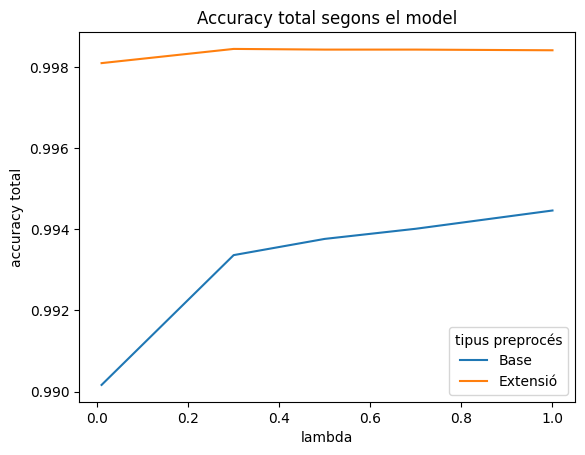

In [ ]:
sns.lineplot(data=df, x="lambda", y="accuracy total", hue="tipus preprocés")
plt.title("Accuracy total segons el model")


### Gràfic [2]

Text(0.5, 1.0, "Temps d'execució segons el model")

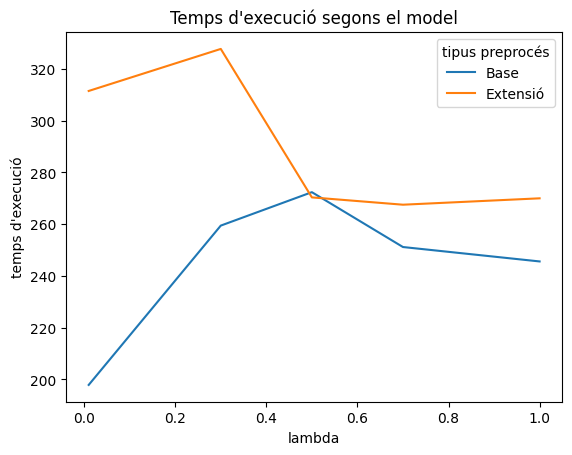

In [ ]:
sns.lineplot(data=df, x="lambda", y="temps d'execució", hue="tipus preprocés")
plt.title("Temps d'execució segons el model")
# Temps d'execució de la matriu de confusió segons el model


### Gràfic [3]

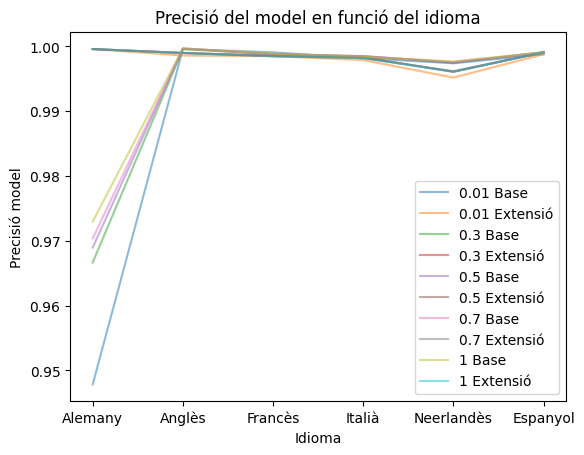

In [ ]:
# Obtenir les dades de la matriu
idiomas = ['Alemany', 'Anglès', 'Francès', 'Italià', 'Neerlandès', 'Espanyol']
precisions = [[fila[2], fila[3], fila[4], fila[5], fila[6], fila[7]] for fila in m]

# Crear la gràfica de barres
for i in range(len(m)):
    plt.plot(idiomas, precisions[i], alpha=0.5, label=str(m[i][0]) + ' ' + m[i][1])

# Afegir etiquetes i llegenda
plt.xlabel('Idioma')
plt.ylabel('Precisió model')
plt.title('Precisió del model en funció del idioma')
plt.legend()

# Mostrar la gràfica
plt.show()


### Gràfic Matriu de confusió

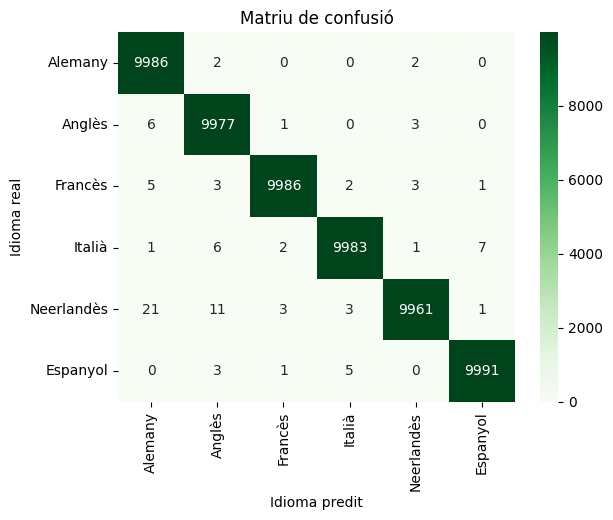

In [ ]:
# Crear la matriu de confusió
cm = np.array(millor_matriu)

# Crear el mapa de calor
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=['Alemany', 'Anglès', 'Francès', 'Italià', 'Neerlandès', 'Espanyol'], yticklabels=[
            'Alemany', 'Anglès', 'Francès', 'Italià', 'Neerlandès', 'Espanyol'])
plt.xlabel("Idioma predit")
plt.ylabel("Idioma real")
plt.title("Matriu de confusió")
plt.show()


## Conclusions
En aquest treball, hem realitzat dos models diferents que varien en el seu preprocessat: el model ‘Base’, que aplica un preprocessat bàsic, i el model ‘Extensió’, que aplica un filtre més específic agafant només els caràcters més comuns de cada idioma. Hem analitzat les diferències en l’accuracy i el temps d’execució entre aquests dos models, així com l’efecte del paràmetre lambda, al qual li hem donat 5 valors diferents (0.01,0.3,0.5,0.7,1).

Els resultats del gràfic [1] mostren que, en general, l’accuracy dels dos models és satisfactori, superant en tots els casos el 0.99. Això vol dir que el model identifica l’idioma correctament el 99% de les vegades, independentment del preprocessat i del paràmetre lambda. No obstant això, el model ‘Extensió’ és més precís que el model ‘Base’. En quant a la lambda, veiem que influeix de forma més significativa en el model ‘Base’; a mesura que augmentem el seu valor, millora l’accuracy. Per tant, a nivell d’accuracy, el model ‘Extensió’ amb lambda = 0.3 és el millor, que és el model extret amb la experimentació.

D’altra banda, el millor model en quant a accuracy (model ‘Extensió’ amb lambda = 0.3) és al mateix temps el que tarda més, gràfic[2]. Així doncs, haurem de replantejar quin és el millor model fent un balanç entre l’accuracy i el temps d’execució. En general, el model ‘Base’ té un temps d’execució més baix. Comparant el temps d’execució i l’accuracy, podem concloure que tots els models ‘Extensió’ amb lambda igual o superior a 0.5 són els millors; així refermem que lambda = 0.5 és un bon valor predeterminat.

Finalment, l’anàlisi de les accuracies de cada idioma en concret mostra que l’alemany presenta una accuracy més baixa per a tots els models ‘Base’. Això pot ser degut a diferents factors, com ara la complexitat de l’idioma o la quantitat de dades disponibles per a l’entrenament del model. Això ens porta a dir, que l’extensió del preprocessat és útil per a no confondre l’alemany, però té una repercussió negativa sobre el Neerlandès, encara que la diferència és més baixa. 

En resum, aquest treball ha permès crear i comparar dos models diferents per a la identificació d’idiomes, analitzant les diferències en l’accuracy i el temps d’execució entre ells, així com l’efecte del paràmetre lambda. Els resultats mostren que el model ‘Extensió’ és més precís que el model ‘Base’, però també té un temps d’execució més elevat. Així doncs, la selecció del millor model depèn del balanç entre l’accuracy i el temps d’execució. Finalment, podem concloure que el model 'Extensió' amb lambda = 0,5 és la millor opció per a la detecció d'idiomes, proporcionant un equilibri adequat entre precisió i temps d'execució.


# Prova el teu propi text

In [1]:
#Llibreries necessàries
import ipywidgets as widgets
from ipywidgets import interact, HBox, VBox
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

In [2]:
def identify(prepro,lam,ubi):
    f = open(ubi, encoding="utf8")
    text = f.readlines()
    identificador_idioma(text,lam,prepro)

In [4]:
dropdown = widgets.Dropdown(
    options=["Base", "Extensió"],
    value='Extensió',
    description='Preprocessat:',
    disabled=False,
)

slider = widgets.FloatSlider(
    value=0.5,
    min=0.01,
    max=1,
    step=0.01,
    description='Lambda:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

text = widgets.Text(
    value='dades/deu_tst.txt',
    placeholder='Type something',
    description="Ubicació de l'arxiu:",
    disabled=False   
)

container = widgets.VBox([dropdown, slider, text])

def on_button_click(b):
    with output:
        identificar(dropdown.value, slider.value, text.value)

def identificar(preprocessat, P_lambda , Ubicacio):
    clear_output(wait=True)
    print("Pot tardar una mica...")
    print("L'idioma del text és: ",identify(preprocessat, P_lambda , Ubicacio))

output = widgets.Output()
button = widgets.Button(description="Identificar")
button.on_click(on_button_click)

widgets_box = widgets.VBox([container, button, output])
display(widgets_box)

slider.layout.width = '400px'
style1 = {'description_width': 'initial'}
slider.style = style1

style2 = {'description_width': 'initial'}
text.style = style2